In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("labeled_add_news.xlsx")
df = df[["title", "summary", "content", "topic"]]
df = df.fillna(str)
df = df.astype(str)

In [ ]:
df['text'] = df['title'] + " " + df['summary'] + " " + df['content']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['topic']
)

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).astype('float32')
X_test_vec = vectorizer.transform(X_test).astype('float32')
vocab_size = len(vectorizer.vocabulary_)

In [ ]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)
n_classes = y_train_cat.shape[1]

In [ ]:
layer1_size = vocab_size
layer2_size = max(1, vocab_size // 6)      # Защита от нулевого размера
layer3_size = max(1, layer2_size // 4)     # Защита от нулевого размера

In [ ]:
model = Sequential([
    Dense(layer2_size, activation='relu', input_shape=(layer1_size,)),
    Dense(layer3_size, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall']
)

NameError: name 'tf' is not defined

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    TensorBoard(log_dir='./logs')
]

In [ ]:
history = model.fit(
    X_train_vec, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_vec, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
 67/436 ━━━━━━━━━━━━━━━━━━━━ 21:04 3s/step - Precision: 0.1444 - Recall: 0.0153 - accuracy: 0.1453 - loss: 2.6228

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_topic(title, summary, content):
    text = f"{title} {summary} {content}"
    vector = vectorizer.transform([text]).astype('float32')
    prediction = model.predict(vector)
    return label_encoder.inverse_transform([np.argmax(prediction)])[0]

In [ ]:
plot_history(history)

Using device: cuda
Epoch 1/20: Train Loss: 2.0812, Train Acc: 0.1639 | Val Loss: 2.0626, Val Acc: 0.1705
Epoch 2/20: Train Loss: 2.0304, Train Acc: 0.2168 | Val Loss: 2.0593, Val Acc: 0.1667
Epoch 3/20: Train Loss: 1.9579, Train Acc: 0.2564 | Val Loss: 2.0764, Val Acc: 0.1586
EarlyStopping counter: 1/5
Epoch 4/20: Train Loss: 1.8100, Train Acc: 0.3512 | Val Loss: 2.1695, Val Acc: 0.1705
EarlyStopping counter: 2/5
Epoch 5/20: Train Loss: 1.5966, Train Acc: 0.4589 | Val Loss: 2.2166, Val Acc: 0.1667
EarlyStopping counter: 3/5
Epoch 6/20: Train Loss: 1.3067, Train Acc: 0.5929 | Val Loss: 2.3532, Val Acc: 0.1641
EarlyStopping counter: 4/5
Epoch 7/20: Train Loss: 0.9905, Train Acc: 0.7115 | Val Loss: 2.6042, Val Acc: 0.1561
EarlyStopping counter: 5/5
Early stopping triggered!


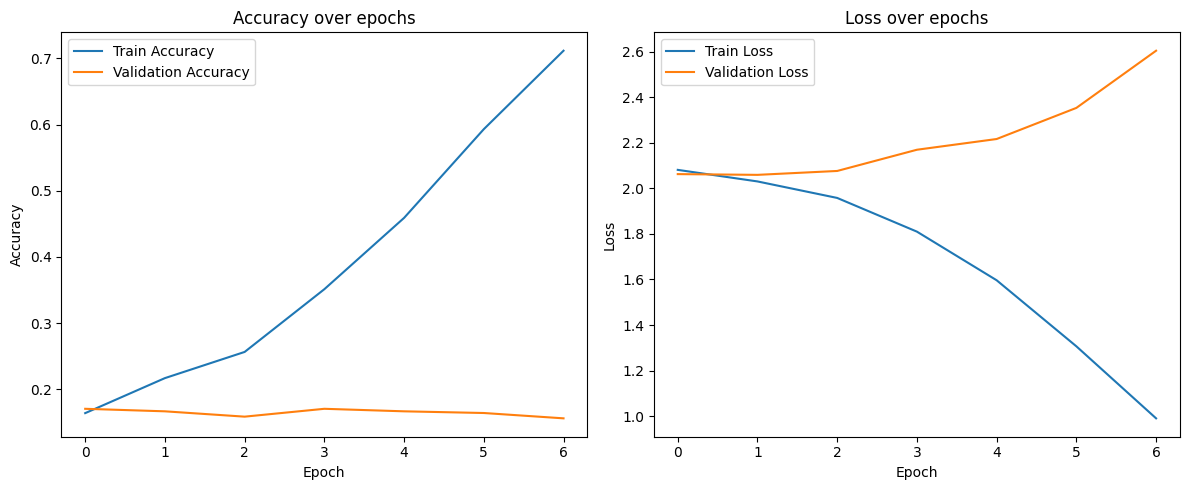

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Загрузка данных
df = pd.read_excel("labeled_add_news.xlsx")
df = df[["title", "summary", "content", "topic"]]
df = df.fillna(str)
df = df.astype(str)

# Подготовка текста
df['text'] = df['title'] + " " + df['summary'] + " " + df['content']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['topic']
)

# Векторизация текста
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).astype('float32')
X_test_vec = vectorizer.transform(X_test).astype('float32')
vocab_size = len(vectorizer.vocabulary_)

# Кодирование меток
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
n_classes = len(label_encoder.classes_)

# Конвертация в PyTorch тензоры и перенос на устройство
X_train_tensor = torch.tensor(X_train_vec.toarray()).to(device)
X_test_tensor = torch.tensor(X_test_vec.toarray()).to(device)
y_train_tensor = torch.tensor(y_train_enc).long().to(device)
y_test_tensor = torch.tensor(y_test_enc).long().to(device)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 2048  # Большой batch_size для GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Определение модели
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.dropout1 = nn.Dropout(0.5)  # Добавлен Dropout
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.dropout2 = nn.Dropout(0.3)  # Добавлен Dropout
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Применяем Dropout
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)  # Применяем Dropout
        x = self.fc3(x)
        return x

# Инициализация модели и перенос на устройство
layer1_size = vocab_size
layer2_size = max(1, vocab_size // 6)
layer3_size = max(1, layer2_size // 4)

model = NeuralNetwork(layer1_size, layer2_size, layer3_size, n_classes).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

# Обучение модели
epochs = 20
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter}/{patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break  # Прерываем обучение

# Визуализация
def plot_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(train_losses, val_losses, train_accs, val_accs)

# Функция для предсказания
def predict_topic(title, summary, content):
    model.eval()
    text = f"{title} {summary} {content}"
    vector = vectorizer.transform([text]).astype('float32')
    inputs = torch.tensor(vector.toarray()).float().to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return label_encoder.inverse_transform(predicted.cpu().numpy())[0]

Using device: cuda
Max sequence length: 1011


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 1/50: Train Loss: 2.3694, Train Acc: 0.1361 | Val Loss: 2.0866, Val Acc: 0.1650 | LR: 0.001000
Epoch 2/50: Train Loss: 2.1320, Train Acc: 0.1739 | Val Loss: 2.0639, Val Acc: 0.1612 | LR: 0.001000
Epoch 3/50: Train Loss: 2.0596, Train Acc: 0.1901 | Val Loss: 2.0845, Val Acc: 0.1768 | LR: 0.001000
EarlyStopping counter: 1/5
Epoch 4/50: Train Loss: 2.0299, Train Acc: 0.2052 | Val Loss: 2.0599, Val Acc: 0.1654 | LR: 0.001000
Epoch 5/50: Train Loss: 2.0135, Train Acc: 0.2114 | Val Loss: 2.0598, Val Acc: 0.1616 | LR: 0.001000
Epoch 6/50: Train Loss: 1.9989, Train Acc: 0.2219 | Val Loss: 2.0630, Val Acc: 0.1751 | LR: 0.001000
EarlyStopping counter: 1/5
Epoch 7/50: Train Loss: 1.9882, Train Acc: 0.2277 | Val Loss: 2.0614, Val Acc: 0.1722 | LR: 0.000500
EarlyStopping counter: 2/5
Epoch 8/50: Train Loss: 1.9489, Train Acc: 0.2537 | Val Loss: 2.0567, Val Acc: 0.1662 | LR: 0.000500
Epoch 9/50: Train Loss: 1.9330, Train Acc: 0.2603 | Val Loss: 2.0745, Val Acc: 0.1701 | LR: 0.000500
EarlyStopp

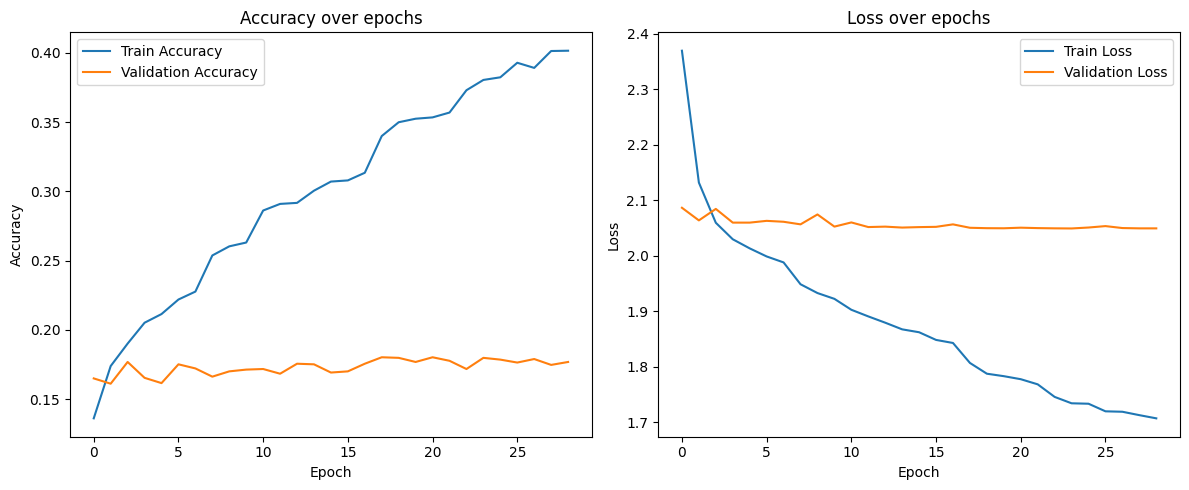

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Загрузка данных
df = pd.read_excel("labeled_add_news.xlsx")
df = df[["title", "summary", "content", "topic"]]
df = df.fillna('')
df = df.astype(str)

# Подготовка текста
df['text'] = df['title'] + " " + df['summary'] + " " + df['content']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['topic']
)

# Создание словаря и преобразование текста в последовательности индексов
word_counter = Counter()
for text in df['text']:
    words = text.split()
    word_counter.update(words)

vocab = {word: idx+1 for idx, (word, _) in enumerate(word_counter.most_common())}  # 0 зарезервирован для паддинга
vocab_size = len(vocab) + 1  # +1 для паддинга

# Функция для преобразования текста в последовательность индексов
def text_to_sequence(text):
    words = text.split()
    return [vocab.get(word, 0) for word in words]  # 0 для слов вне словаря

# Преобразование текстов в последовательности
X_train_seq = [torch.tensor(text_to_sequence(text)) for text in X_train]
X_test_seq = [torch.tensor(text_to_sequence(text)) for text in X_test]

# Параметры последовательности
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))  # Используем 95-й перцентиль для максимальной длины
print(f"Max sequence length: {max_len}")

# Функция для ручного паддинга последовательностей
def manual_pad_sequence(sequences, max_len, padding_value=0):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_seq = seq[:max_len]
        else:
            padded_seq = torch.cat([
                seq,
                torch.full((max_len - len(seq),), padding_value, dtype=seq.dtype)
            ])
        padded_sequences.append(padded_seq)
    return torch.stack(padded_sequences)

# Паддинг последовательностей
X_train_padded = manual_pad_sequence(X_train_seq, max_len)
X_test_padded = manual_pad_sequence(X_test_seq, max_len)

# Кодирование меток
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
n_classes = len(label_encoder.classes_)

# Конвертация в тензоры PyTorch
X_train_tensor = X_train_padded.to(device)
X_test_tensor = X_test_padded.to(device)
y_train_tensor = torch.tensor(y_train_enc).long().to(device)
y_test_tensor = torch.tensor(y_test_enc).long().to(device)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  # Уменьшенный batch_size для CNN
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Определение CNN модели
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_size, dropout_rate=0.5):
        super(TextCNN, self).__init__()

        # Слой эмбеддингов
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Сверточные слои
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters,
                      kernel_size=fs, padding='same')
            for fs in filter_sizes
        ])

        # Полносвязный слой
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_size)

        # Dropout и активации
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Эмбеддинги: [batch_size, seq_len] -> [batch_size, seq_len, embed_dim]
        x = self.embedding(x)

        # Перестановка размерностей для Conv1d: [batch_size, embed_dim, seq_len]
        x = x.permute(0, 2, 1)

        # Применение свертки и max-pooling
        conv_outputs = []
        for conv in self.convs:
            # Свертка: [batch_size, num_filters, seq_len]
            conv_out = conv(x)
            # ReLU
            conv_out = self.relu(conv_out)
            # Global max pooling: [batch_size, num_filters]
            pooled = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(pooled)

        # Объединение результатов всех сверток
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)

        # Полносвязный слой
        logits = self.fc(x)
        return logits

# Параметры модели
embed_dim = 100      # Размерность эмбеддингов
num_filters = 128    # Количество фильтров на каждый размер ядра
filter_sizes = [3, 4, 5]  # Размеры ядер свертки
dropout_rate = 0.5   # Dropout

model = TextCNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_filters=num_filters,
    filter_sizes=filter_sizes,
    output_size=n_classes,
    dropout_rate=dropout_rate
).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Добавим learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Обучение модели
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Обновляем scheduler
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter}/{patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_cnn_model.pth'))

# Визуализация
def plot_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(train_losses, val_losses, train_accs, val_accs)

# Функция для предсказания
def predict_topic(title, summary, content):
    model.eval()
    text = f"{title} {summary} {content}"
    sequence = text_to_sequence(text)
    # Создаем тензор и обрезаем/дополняем до max_len
    if len(sequence) > max_len:
        sequence_tensor = torch.tensor(sequence[:max_len], dtype=torch.long)
    else:
        sequence_tensor = torch.cat([
            torch.tensor(sequence, dtype=torch.long),
            torch.zeros(max_len - len(sequence), dtype=torch.long)
        ])
    inputs = sequence_tensor.unsqueeze(0).to(device)  # Добавляем размерность батча

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return label_encoder.inverse_transform(predicted.cpu().numpy())[0]

Using device: cuda
Original TF-IDF dimension: 9728
Reduced dimension: 1000
Explained variance ratio: 0.6505
Epoch 1/50: Train Loss: 2.0793, Train Acc: 0.1114 | Val Loss: 2.0765, Val Acc: 0.1145 | LR: 0.001000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/50: Train Loss: 2.0754, Train Acc: 0.1278 | Val Loss: 2.0730, Val Acc: 0.1344 | LR: 0.001000
Epoch 3/50: Train Loss: 2.0712, Train Acc: 0.1324 | Val Loss: 2.0696, Val Acc: 0.1340 | LR: 0.001000
Epoch 4/50: Train Loss: 2.0680, Train Acc: 0.1535 | Val Loss: 2.0657, Val Acc: 0.1781 | LR: 0.001000
Epoch 5/50: Train Loss: 2.0630, Train Acc: 0.1755 | Val Loss: 2.0612, Val Acc: 0.1781 | LR: 0.001000
Epoch 6/50: Train Loss: 2.0587, Train Acc: 0.1759 | Val Loss: 2.0561, Val Acc: 0.1781 | LR: 0.001000
Epoch 7/50: Train Loss: 2.0526, Train Acc: 0.1814 | Val Loss: 2.0510, Val Acc: 0.1781 | LR: 0.001000
Epoch 8/50: Train Loss: 2.0486, Train Acc: 0.1792 | Val Loss: 2.0470, Val Acc: 0.1781 | LR: 0.001000
Epoch 9/50: Train Loss: 2.0442, Train Acc: 0.1762 | Val Loss: 2.0446, Val Acc: 0.1781 | LR: 0.001000
Epoch 10/50: Train Loss: 2.0425, Train Acc: 0.1804 | Val Loss: 2.0435, Val Acc: 0.1781 | LR: 0.001000
Epoch 11/50: Train Loss: 2.0411, Train Acc: 0.1796 | Val Loss: 2.0423, Val Acc: 0.1781 | L

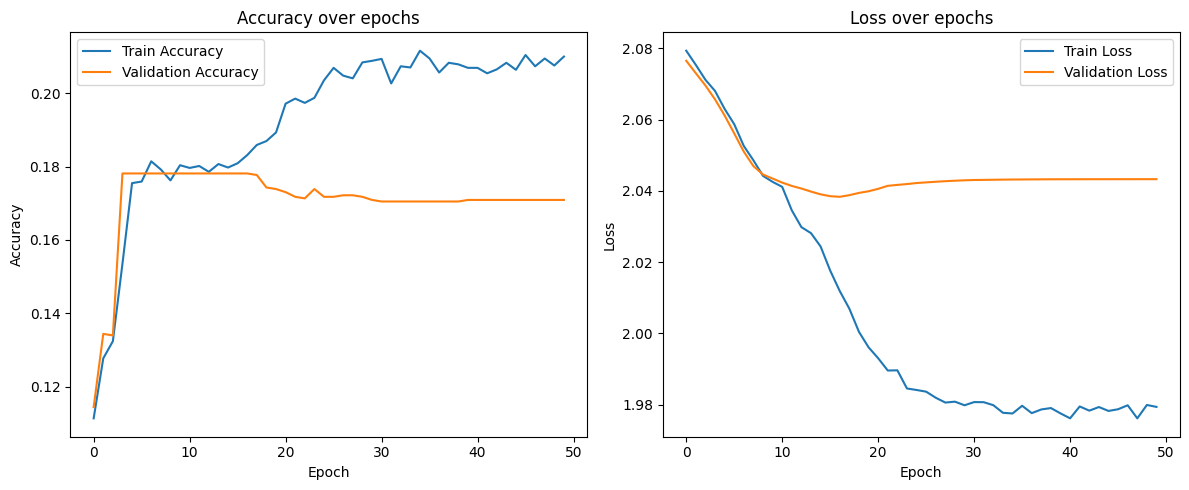

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # Изменено на TF-IDF
from sklearn.decomposition import TruncatedSVD  # Для сокращения размерности
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Определение устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Загрузка данных
df = pd.read_excel("labeled_add_news.xlsx")
df = df[["title", "summary", "content", "topic"]]
df = df.fillna('')
df = df.astype(str)

# Подготовка текста
df['text'] = df['title'] + " " + df['summary'] + " " + df['content']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['topic']
)

# TF-IDF векторизация текста
vectorizer = TfidfVectorizer()  # Используем TF-IDF вместо CountVectorizer
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Сокращение размерности с помощью TruncatedSVD
n_components = 1000  # Выберите значение, подходящее для ваших данных
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf).astype('float32')
X_test_reduced = svd.transform(X_test_tfidf).astype('float32')

print(f"Original TF-IDF dimension: {X_train_tfidf.shape[1]}")
print(f"Reduced dimension: {X_train_reduced.shape[1]}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

# Кодирование меток
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
n_classes = len(label_encoder.classes_)

# Конвертация в PyTorch тензоры и перенос на устройство
X_train_tensor = torch.tensor(X_train_reduced).to(device)
X_test_tensor = torch.tensor(X_test_reduced).to(device)
y_train_tensor = torch.tensor(y_train_enc).long().to(device)
y_test_tensor = torch.tensor(y_test_enc).long().to(device)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Определение модели
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Инициализация модели и перенос на устройство
layer1_size = n_components  # Теперь размерность равна количеству компонент SVD
layer2_size = max(1, n_components // 6)
layer3_size = max(1, layer2_size // 4)

model = NeuralNetwork(layer1_size, layer2_size, layer3_size, n_classes).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Добавлен learning rate

# Добавим learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Обучение модели
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Обновляем scheduler
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # # Ранняя остановка
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     counter = 0
    # else:
    #     counter += 1
    #     print(f'EarlyStopping counter: {counter}/{patience}')
    #     if counter >= patience:
    #         print('Early stopping triggered!')
    #         break

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_model.pth'))

# Визуализация
def plot_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(train_losses, val_losses, train_accs, val_accs)

# Функция для предсказания
def predict_topic(title, summary, content):
    model.eval()
    text = f"{title} {summary} {content}"

    # Преобразование текста: TF-IDF + SVD
    tfidf_vector = vectorizer.transform([text])
    reduced_vector = svd.transform(tfidf_vector).astype('float32')

    inputs = torch.tensor(reduced_vector).float().to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return label_encoder.inverse_transform(predicted.cpu().numpy())[0]